# Exploratory Data Analysis of Weather in Illinois

In [1]:
import pandas as pd # DataFrame library
import numpy as np # Array library
import matplotlib.pyplot as plt # Plotting library
import folium # Geographical map library
from folium.plugins import MarkerCluster, DualMap, TimestampedGeoJson # Allows multiple markers to be created at once without slowing down the rendering of the map

In [2]:
desired_cols = ["id", "date", "time", "name", "element", "value", "latitude", "longitude", "elevation"] # columns that are going to be used for analysis
desired_types = {"id": "string", 
                 "date": "string", 
                 "time": "string", 
                 "name": "string", 
                 "element": "string", 
                 "value": "float", 
                 "latitude": "float", 
                 "longitude": "float",
                 "elevation": "float"} # the data types that will be assigned per column
raw_weather_data = pd.read_csv("./data/raw_illinois_weather_data.csv", usecols = desired_cols, dtype = desired_types) # load the data based on the desired data types and columns
raw_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4741860 entries, 0 to 4741859
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         string 
 1   date       string 
 2   time       string 
 3   element    string 
 4   value      float64
 5   latitude   float64
 6   longitude  float64
 7   name       string 
 8   elevation  float64
dtypes: float64(4), string(5)
memory usage: 325.6 MB


In [3]:
raw_weather_data.shape

(4741860, 9)

In [4]:
raw_weather_data["time"].fillna("0000", inplace = True) # replace all nan values with "0000"

In [5]:
np.sort(raw_weather_data["time"].apply(len).unique()) # helps to verify how many unique length characters there was in the "time" column. 
# there should only be one of length 4 characters to be able to parse into datetime format.

array([4])

In [6]:
raw_weather_data["time"] = raw_weather_data["time"].apply(lambda x: f"{x[:-2]}:{x[-2:]}:00") # added a seconds placeholder for parsing
raw_weather_data["time"] = pd.to_timedelta(raw_weather_data["time"]) # converts string format to datetime format for the time column

In [7]:
raw_weather_data["date"] = pd.to_datetime(raw_weather_data["date"]) # converts the string format to a datetime format for the date column
raw_weather_data["date"] = raw_weather_data["date"] + raw_weather_data["time"] # combines date and time into the same column which can be accessed via object attributes
raw_weather_data.drop(columns = ["time"], inplace = True) # drops the redundant time column
raw_weather_data

,id,date,element,value,latitude,longitude,name,elevation
0,USC00118353,2019-10-07 00:00:00,TMAX,189.0,41.0908,-88.8158,STREATOR 3 SE,185.9
1,USC00118389,2019-10-07 07:00:00,TMAX,211.0,39.5608,-88.6089,SULLIVAN 3S,195.1
2,USC00118353,2019-10-08 00:00:00,TMIN,89.0,41.0908,-88.8158,STREATOR 3 SE,185.9
3,USC00116344,2019-10-08 00:00:00,TOBS,72.0,40.1100,-87.9567,OGDEN,205.7
4,USC00118389,2019-10-08 07:00:00,TMAX,233.0,39.5608,-88.6089,SULLIVAN 3S,195.1
...,...,...,...,...,...,...,...,...
4741855,USC00112745,2016-08-02 07:00:00,TOBS,206.0,42.3161,-90.2269,ELIZABETH,205.7
4741856,USC00112745,2016-05-04 07:00:00,TMIN,39.0,42.3161,-90.2269,ELIZABETH,205.7
4741857,USC00112745,2016-08-18 07:00:00,TMAX,300.0,42.3161,-90.2269,ELIZABETH,205.7
4741858,USC00112745,2016-08-23 07:00:00,TMIN,100.0,42.3161,-90.2269,ELIZABETH,205.7


### The cell below pivots the element values into columns which are more useful in column format.

In [8]:
raw_weather_pivot = raw_weather_data.pivot(columns = "element", values = "value")
raw_weather_pivot

element,TMAX,TMIN,TOBS
0,189.0,NaN,NaN
1,211.0,NaN,NaN
2,NaN,89.0,NaN
3,NaN,NaN,72.0
4,233.0,NaN,NaN
...,...,...,...
4741855,NaN,NaN,206.0
4741856,NaN,39.0,NaN
4741857,300.0,NaN,NaN
4741858,NaN,100.0,NaN


In [9]:
transformed_data = pd.concat([raw_weather_data, raw_weather_pivot], axis = 1) # combine the newly generated columns with the existing dataframe
transformed_data.drop(columns = ["element", "value"], inplace = True) # drop the element and value columns
transformed_data["TMIN"] = 9/5 * (transformed_data["TMIN"] / 10) + 32 # converting from tenths of a degree Celsius to Fahrenheit
transformed_data["TMAX"] = 9/5 * (transformed_data["TMAX"] / 10) + 32 
transformed_data["TOBS"] = 9/5 * (transformed_data["TOBS"] / 10) + 32
transformed_data.to_csv("./data/transformed_illinois_weather_data.csv", index = False)
transformed_data

,id,date,latitude,longitude,name,elevation,TMAX,TMIN,TOBS
0,USC00118353,2019-10-07 00:00:00,41.0908,-88.8158,STREATOR 3 SE,185.9,66.02,NaN,NaN
1,USC00118389,2019-10-07 07:00:00,39.5608,-88.6089,SULLIVAN 3S,195.1,69.98,NaN,NaN
2,USC00118353,2019-10-08 00:00:00,41.0908,-88.8158,STREATOR 3 SE,185.9,NaN,48.02,NaN
3,USC00116344,2019-10-08 00:00:00,40.1100,-87.9567,OGDEN,205.7,NaN,NaN,44.96
4,USC00118389,2019-10-08 07:00:00,39.5608,-88.6089,SULLIVAN 3S,195.1,73.94,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4741855,USC00112745,2016-08-02 07:00:00,42.3161,-90.2269,ELIZABETH,205.7,NaN,NaN,69.08
4741856,USC00112745,2016-05-04 07:00:00,42.3161,-90.2269,ELIZABETH,205.7,NaN,39.02,NaN
4741857,USC00112745,2016-08-18 07:00:00,42.3161,-90.2269,ELIZABETH,205.7,86.00,NaN,NaN
4741858,USC00112745,2016-08-23 07:00:00,42.3161,-90.2269,ELIZABETH,205.7,NaN,50.00,NaN


### This cell below plots the minimum, maximum, and observed temperatures.

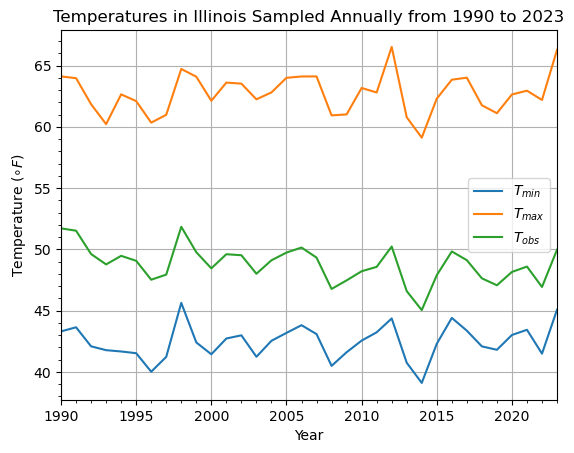

In [10]:
# Resample the temperature data annually and calculate the mean
numeric_data = transformed_data.select_dtypes(include = ["datetime64[ns]", "float"])
resampled_data = numeric_data.resample("Y", on="date").mean()
resampled_data.index = pd.to_datetime(resampled_data.index)
tmin_label = r"$T_{min}$"
tmax_label = r"$T_{max}$"
tobs_label = r"$T_{obs}$"

# Plotting TMIN, TMAX, and TOBS
plt.plot(resampled_data.index.year, resampled_data["TMIN"], label= tmin_label)
plt.plot(resampled_data.index.year, resampled_data["TMAX"], label= tmax_label)
plt.plot(resampled_data.index.year, resampled_data["TOBS"], label= tobs_label)

# Set labels and title
plt.xlabel("Year")
plt.ylabel(r"Temperature ($\circ F$)")
plt.title("Temperatures in Illinois Sampled Annually from 1990 to 2023")

# Display the legend
plt.legend(loc="best")

# Fixes the x-range so that it's between 1990 and 2023
plt.xlim(resampled_data.index.year.min(), resampled_data.index.year.max())

# Display the grid
plt.grid()

# Display minor ticks
plt.minorticks_on()

# Show the plot
plt.show()

### The cell below plots the temeprature difference for the minimum, maximum, and observed temperatures.

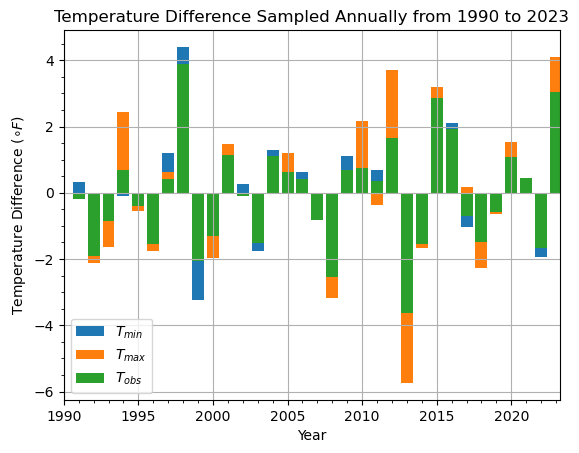

In [22]:
# Plotting the temperature gradient (difference) for TMIN, TMAX, TOBS
plt.bar(resampled_data.index.year, resampled_data["TMIN"].diff(), label = tmin_label)
plt.bar(resampled_data.index.year, resampled_data["TMAX"].diff(), label = tmax_label)
plt.bar(resampled_data.index.year, resampled_data["TOBS"].diff(), label = tobs_label)

# Adding labels and legend
plt.xlabel("Year")
plt.ylabel(r"Temperature Difference ($\circ F$)")
plt.legend(loc = "lower left")

# Fix the x-range so that all the bars for each year display properly
plt.xlim(resampled_data.index.year.min(), resampled_data.index.year.max() + 0.25)

# Adding a title
plt.title("Temperature Difference Sampled Annually from 1990 to 2023")

# Display grid and minor ticks
plt.grid()
plt.minorticks_on()

# Show the plot
plt.show()

In [12]:
total_number_of_stations = 1927 # See extracting_weather_data notebook for the query

In [13]:
transformed_data["name"].nunique() # number of stations in Illinois with respect to TMIN, TMAX, TOBS

209

In [14]:
f"{transformed_data["name"].nunique() / total_number_of_stations * 100:.2f}% of stations are temperature measurements."

'10.85% of stations are temperature measurements.'

In [15]:
num_obs_per_station = transformed_data.groupby("name", as_index = False)["date"].count() # number of observations per station w.r.t. TMIN, TMAX, TOBS
num_obs_per_station.rename(columns = {"date": "obs_count"}, inplace = True)
num_obs_per_station

,name,obs_count
0,ALBION,15352
1,ALEDO,35767
2,ALTON - MELVIN PRICE L&D,31602
3,ALTONA,17881
4,ANNA 4 N,25718
...,...,...
204,WAUKEGAN,12384
205,WHEATON 3 SE,22074
206,WHITE HALL 1 E,36520
207,WINCHESTER,17375


In [16]:
num_obs_per_station.describe()

,obs_count
count,209.000000
mean,22688.325359
std,11377.144773
min,1.000000
25%,14157.000000
50%,24173.000000
75%,33674.000000
max,37161.000000


In [17]:
stations_in_between_quantiles = (num_obs_per_station["obs_count"] > num_obs_per_station["obs_count"].quantile(0.25)) & (num_obs_per_station["obs_count"] < num_obs_per_station["obs_count"].quantile(0.75))
num_obs_per_station[stations_in_between_quantiles]

,name,obs_count
0,ALBION,15352
2,ALTON - MELVIN PRICE L&D,31602
3,ALTONA,17881
4,ANNA 4 N,25718
5,ANTIOCH,17156
...,...,...
198,VANDALIA,24391
200,VIRDEN,22900
203,WATSEKA 2NW,31809
205,WHEATON 3 SE,22074


In [18]:
num_obs_per_station.min() # Station with the least number of observations w.r.t. TMIN, TMAX, TOBS

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_2073/2289167633.py:1: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  num_obs_per_station.min() # Station with the least number of observations w.r.t. TMIN, TMAX, TOBS


name         ALBION
obs_count         1
dtype: object

In [19]:
num_obs_per_station.max() # Station with the most number of observations w.r.t. TMIN, TMAX, TOBS

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_2073/2916560759.py:1: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  num_obs_per_station.max() # Station with the most number of observations w.r.t. TMIN, TMAX, TOBS


name         WINDSOR
obs_count      37161
dtype: object

In [20]:
def map_of_temps_for_each_year(df, start_year, end_year):
    """Generates an animated map with a time slider for each year.

    Args:
        df (pandas.DataFrame): the dataset that will be plotted on the map
        start_year (int): The starting year for the range of years
        end_year (int): The ending year for the range of years
    """
    # Create a base map
    base_map = folium.Map(location=[df["latitude"].dropna().mean(), df["longitude"].dropna().mean()], zoom_start=6)

    # Create marker cluster for base map
    marker_cluster_base = MarkerCluster().add_to(base_map)

    # Prepare data for TimestampedGeoJson
    features = []
    for year in range(start_year, end_year + 1):
        year_data = df[df["date"].dt.year == year].dropna(subset=["TOBS"])
        year_data["TOBS_avg"] = year_data["TOBS"].rolling(365).mean()

        # Add markers for each data point
        for index, row in year_data.iterrows():
            feature = {
                'type': 'Feature',
                'geometry': {
                    'type': 'Point',
                    'coordinates': [row["longitude"], row["latitude"]],
                },
                'properties': {
                    'time': row["date"].isoformat(),
                    'popup': f"Temperature: {row['TOBS_avg']:.0f}°F\nStation Name: {row['name']}",
                }
            }
            features.append(feature)

    # Create TimestampedGeoJson layer
    ts_geojson = TimestampedGeoJson({
        'type': 'FeatureCollection',
        'features': features,
    }, period='P1Y', add_last_point=True)

    # Add TimestampedGeoJson to the base map
    base_map.add_child(ts_geojson)

    # Add marker cluster for base map
    marker_cluster_base.add_to(base_map)

    # Save the map
    base_map.save("Yearly Temperature Map.html")

In [21]:
map_of_temps_for_each_year(transformed_data, 1990, 2023)